## Scratch notebook

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
def load_egio_data(egio_file):
    """Load EGIO orthologous exon mappings"""
    print(f"Loading orthology data from {egio_file}...")
    
    # Define column names based on the format you provided
    columns = ['Group', 'hsaEnsemblG', 'hsaPos', 'musEnsemblG', 'musPos', 'Iden', 'Type']
    
    # Load data
    df = pd.read_csv(egio_file, sep='\t', names=columns, skiprows=1)
    
    # Clean up whitespace in string columns
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.strip()
    
    return df

def load_eei_network(eei_file):
    """Load EEI network from PISA or EPPIC output"""
    print(f"Loading EEI network from {eei_file}...")
    
    # Define column names based on the format you provided
    columns = ['exon1', 'exon2', 'AA1', 'AA2', 'protein1', 'protein2', 
               'FreeEnergy', 'BuriedArea', 'Hydrogen', 'Disulphide', 
               'Saltbridge', 'Covalent', 'BuriedAreaAbs', 'SolAccAreaAbs', 
               'PDBID', 'allAA']
    
    # Load data
    df = pd.read_csv(eei_file, sep='\t', names=columns, skiprows=1)
    
    # Clean up whitespace in string columns
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.strip()
    
    return df

In [3]:

def create_coordinate_to_id_map(egio_df, species='mus'):
    """Create mapping from genomic coordinates to exon IDs"""
    coordinate_to_id = {}
    
    if species == 'mus':
        pos_col = 'musPos'
    else:  # Assuming human otherwise
        pos_col = 'hsaPos'
    
    for _, row in egio_df.iterrows():
        if row[pos_col] != 'None' and not pd.isna(row[pos_col]):
            coordinate_to_id[row[pos_col]] = f"Group_{row['Group']}"
    
    return coordinate_to_id

In [4]:
egio_df = load_egio_data('../data/EGIO_results/ExonGroup_testpro_hsa_mus.txt')
egio_df.head()

Loading orthology data from ../data/EGIO_results/ExonGroup_testpro_hsa_mus.txt...


,Group,hsaEnsemblG,hsaPos,musEnsemblG,musPos,Iden,Type
0,1,ENSG00000155657,chr2:178804552:178804642:-1,ENSMUSG00000051747,chr2:76810436:76810526:-1,0.97,1-1
1,2,ENSG00000155657,chr2:178802138:178802341:-1,ENSMUSG00000051747,chr2:76807437:76807640:-1,0.95,1-1
2,3,ENSG00000155657,chr2:178800395:178800682:-1,ENSMUSG00000051747,chr2:76805255:76805542:-1,0.94,1-1
3,4,ENSG00000155657,chr2:178799825:178799910:-1,ENSMUSG00000051747,chr2:76804695:76804780:-1,0.91,1-1
4,5,ENSG00000155657,chr2:178799487:178799731:-1,ENSMUSG00000051747,chr2:76804360:76804601:-1,0.90,1-1


In [5]:
eei_df = load_eei_network('../data/PISA_results/PISA_EEIN_0.5.txt')
eei_df.head()

Loading EEI network from ../data/PISA_results/PISA_EEIN_0.5.txt...


,exon1,exon2,AA1,AA2,protein1,protein2,FreeEnergy,BuriedArea,Hydrogen,Disulphide,Saltbridge,Covalent,BuriedAreaAbs,SolAccAreaAbs,PDBID,allAA
0,ENSE00000662711,ENSE00001454665,1,7,Q13469,P05412,3.726230,0.350759,0,0,0,0,373.691100,1065.3770,1a02,8
1,ENSE00000662710,ENSE00001454665,10,7,Q13469,P05412,6.855897,0.350580,0,0,0,0,696.897630,1987.8428,1a02,17
2,ENSE00003627632,ENSE00001454665,13,25,P15336,P05412,-14.553085,0.406291,2,0,1,0,1596.523682,3929.5110,1t2k,38
3,ENSE00003650786,ENSE00001454665,10,25,P15336,P05412,-16.996852,0.387531,0,0,0,0,1425.834722,3679.2745,1t2k,35
4,ENSE00001454665,ENSE00001152027,21,7,P05412,P01100,-9.881238,0.421948,1,0,0,0,1308.951800,3102.1660,1a02,28


In [6]:
len(egio_df), len(eei_df)

(102903, 24845)

In [7]:
coordinates_dict = create_coordinate_to_id_map(egio_df, species='mus')

In [8]:
# Print the first 10 entries of the coordinate to ID mapping
for i, (coord, group_id) in enumerate(coordinates_dict.items()):
    if i >= 10:
        break
    print(f"{coord} ➝ {group_id}")

chr2:76810436:76810526:-1 ➝ Group_1
chr2:76807437:76807640:-1 ➝ Group_2
chr2:76805255:76805542:-1 ➝ Group_3
chr2:76804695:76804780:-1 ➝ Group_4
chr2:76804360:76804601:-1 ➝ Group_5
chr2:76799965:76800295:-1 ➝ Group_6
chr2:76799484:76799636:-1 ➝ Group_7
chr2:76798740:76798877:-1 ➝ Group_8
chr2:76797398:76797529:-1 ➝ Group_9
chr2:76796121:76796258:-1 ➝ Group_10


In [9]:
def create_orthology_map(egio_df, identity_threshold=0.8):
    """Create mapping between orthologous exons"""
    print(f"Creating orthology map with identity threshold: {identity_threshold}...")
    
    # Initialize orthology maps
    mus_to_hsa = {}
    hsa_to_mus = {}
    
    # Process each row
    for _, row in egio_df.iterrows():
        # Skip entries with None or low identity
        if (row['musPos'] == 'None' or row['hsaPos'] == 'None' or 
            pd.isna(row['musPos']) or pd.isna(row['hsaPos'])):
            continue
        
        try:
            identity = float(row['Iden'])
            if identity < identity_threshold:
                continue
        except:
            continue
            
        # Store mappings in both directions
        mus_to_hsa[row['musPos']] = {
            'hsaPos': row['hsaPos'],
            'identity': identity,
            'type': row['Type']
        }
        
        hsa_to_mus[row['hsaPos']] = {
            'musPos': row['musPos'],
            'identity': identity,
            'type': row['Type']
        }
    
    return {
        'mus_to_hsa': mus_to_hsa,
        'hsa_to_mus': hsa_to_mus
    }

In [10]:
orthology_map_mus_hsa = create_orthology_map(egio_df, identity_threshold=0.8)

Creating orthology map with identity threshold: 0.8...


In [11]:
# Access the mappings
mus_to_hsa = orthology_map_mus_hsa['mus_to_hsa']
hsa_to_mus = orthology_map_mus_hsa['hsa_to_mus']

# Print first 10 mus_to_hsa entries
print("First 10 mus_to_hsa entries:")
for i, (mus_pos, info) in enumerate(mus_to_hsa.items()):
    if i >= 10:
        break
    print(f"{mus_pos} ➝ {info}")

# Print first 10 hsa_to_mus entries
print("\nFirst 10 hsa_to_mus entries:")
for i, (hsa_pos, info) in enumerate(hsa_to_mus.items()):
    if i >= 10:
        break
    print(f"{hsa_pos} ➝ {info}")

First 10 mus_to_hsa entries:
chr2:76810436:76810526:-1 ➝ {'hsaPos': 'chr2:178804552:178804642:-1', 'identity': 0.97, 'type': '1-1'}
chr2:76807437:76807640:-1 ➝ {'hsaPos': 'chr2:178802138:178802341:-1', 'identity': 0.95, 'type': '1-1'}
chr2:76805255:76805542:-1 ➝ {'hsaPos': 'chr2:178800395:178800682:-1', 'identity': 0.94, 'type': '1-1'}
chr2:76804695:76804780:-1 ➝ {'hsaPos': 'chr2:178799825:178799910:-1', 'identity': 0.91, 'type': '1-1'}
chr2:76804360:76804601:-1 ➝ {'hsaPos': 'chr2:178799487:178799731:-1', 'identity': 0.9, 'type': '1-1'}
chr2:76799965:76800295:-1 ➝ {'hsaPos': 'chr2:178794922:178795252:-1', 'identity': 0.83, 'type': '1-1'}
chr2:76799484:76799636:-1 ➝ {'hsaPos': 'chr2:178794399:178794551:-1', 'identity': 0.92, 'type': '1-1'}
chr2:76798740:76798877:-1 ➝ {'hsaPos': 'chr2:178793404:178793541:-1', 'identity': 0.83, 'type': '1-1'}
chr2:76797398:76797529:-1 ➝ {'hsaPos': 'chr2:178792072:178792197:-1', 'identity': 0.84, 'type': '1-1'}
chr2:76796121:76796258:-1 ➝ {'hsaPos': 'chr2:

In [49]:
def predict_human_eeis(eei_df, orthology_map, coordinate_to_id=None):
    """Predict human EEIs based on mouse EEIs and orthology data"""
    print("Predicting human EEIs based on orthology...")
    
    mus_to_hsa = orthology_map['mus_to_hsa']
    predicted_eeis = []
    
    # Process each EEI
    for _, eei in eei_df.iterrows():
        # For this example, we're assuming the EEI file has exon IDs
        # In practice, you might need to map coordinates to IDs
        exon1 = eei['exon1']
        exon2 = eei['exon2']
        
        # If we have coordinate_to_id map, we might need to use it here
        # to convert coordinates to exon IDs if they're in coordinate format
        
        # Get mouse exon coordinates (in a real pipeline, you'd need to map from ID to coordinate)
        # This is a placeholder - you'd need logic to find the coordinates
        mus_exon1_pos = f"Need to find position for {exon1}"
        mus_exon2_pos = f"Need to find position for {exon2}"
        
        # Check if both mouse exons have human orthologs
        if mus_exon1_pos in mus_to_hsa and mus_exon2_pos in mus_to_hsa:
            hsa_exon1_info = mus_to_hsa[mus_exon1_pos]
            hsa_exon2_info = mus_to_hsa[mus_exon2_pos]
            
            # Calculate confidence score based on orthology
            confidence = (hsa_exon1_info['identity'] + hsa_exon2_info['identity']) / 2
            
            # Create predicted human EEI
            predicted_eei = {
                'source_exon1': exon1,
                'source_exon2': exon2,
                'human_exon1_pos': hsa_exon1_info['hsaPos'],
                'human_exon2_pos': hsa_exon2_info['hsaPos'],
                'confidence': confidence,
                'orthology_type': f"{hsa_exon1_info['type']}_{hsa_exon2_info['type']}",
                # Include additional EEI properties from source
                'FreeEnergy': eei['FreeEnergy'],
                'BuriedArea': eei['BuriedArea'],
                'Hydrogen': eei['Hydrogen'],
                'PDBID': eei['PDBID']
            }
            
            predicted_eeis.append(predicted_eei)
    return pd.DataFrame(predicted_eeis)

In [50]:
EEI_prediction_df = predict_human_eeis(eei_df, orthology_map_mus_hsa, coordinate_to_id=coordinates_dict)


Predicting human EEIs based on orthology...


In [51]:
EEI_prediction_df.head()

""


### Creating exon_id to coordinates map

In [54]:
from biomart import BiomartServer

def create_exon_mapping_from_biomart(species, output_file):
    """Extract exon IDs and coordinates from Ensembl BioMart"""
    print(f"Extracting exon data for {species} from Ensembl BioMart...")
    
    # Connect to Ensembl BioMart
    server = BiomartServer("http://www.ensembl.org/biomart")
    mart = server.datasets["mmusculus_gene_ensembl" if species == "mus" else "hsapiens_gene_ensembl"]
    
    # Set up the query
    response = mart.search({
        'attributes': [
            'ensembl_exon_id',
            'chromosome_name',
            'exon_chrom_start',
            'exon_chrom_end',
            'strand'
        ]
    })
    
    # Process the response
    exon_mappings = []
    for line in response.iter_lines():
        if line:
            fields = line.decode('utf-8').split('\t')
            if len(fields) >= 5:
                exon_id = fields[0]
                chrom = fields[1]
                start = fields[2]
                end = fields[3]
                strand = fields[4]
                
                if all([exon_id, chrom, start, end, strand]):
                    # Format: chr:start:end:strand
                    coordinate = f"chr{chrom}:{start}:{end}:{'-1' if strand == '-1' else '1'}"
                    exon_mappings.append((exon_id, coordinate))
    
    # Create a DataFrame and save to file
    df = pd.DataFrame(exon_mappings, columns=['exon_id', 'coordinate'])
    df.to_csv(output_file, sep='\t', index=False, header=False)
    print(f"Saved {len(exon_mappings)} exon mappings to {output_file}")

In [ ]:
create_exon_mapping_from_biomart("mus", "mouse_exon_id_to_coordinate.tsv")


Extracting exon data for mus from Ensembl BioMart...
Saved 770598 exon mappings to mouse_exon_id_to_coordinate.tsv


In [56]:
create_exon_mapping_from_biomart("hsa", "human_exon_id_to_coordinate.tsv")

Extracting exon data for hsa from Ensembl BioMart...
Saved 1111866 exon mappings to human_exon_id_to_coordinate.tsv


In [12]:
def create_id_to_coordinate_map(exon_file):
    """Create mapping from exon IDs to genomic coordinates
    
    Args:
        exon_file: Path to file containing exon ID to coordinate mappings
                   (this could be a processed GTF file)
    
    Returns:
        Dictionary mapping exon IDs to coordinates
    """
    print(f"Loading exon ID to coordinate mappings from {exon_file}...")
    id_to_coordinate = {}
    
    # Read the exon file - format will depend on your data
    # Example format: exon_id\tcoordinate
    df = pd.read_csv(exon_file, sep='\t', header=None, names=['exon_id', 'coordinate'])
    
    for _, row in df.iterrows():
        id_to_coordinate[row['exon_id']] = row['coordinate']
    
    print(f"Loaded {len(id_to_coordinate)} exon ID to coordinate mappings")
    return id_to_coordinate

In [ ]:
id_to_coordinate_map_mus = create_id_to_coordinate_map("../data/mouse_exon_id_to_coordinate.tsv")
id_to_coordinate_map_hsa = create_id_to_coordinate_map("../data/human_exon_id_to_coordinate.tsv")


Loading exon ID to coordinate mappings from ../data/mouse_exon_id_to_coordinate.tsv...
Loaded 770598 exon ID to coordinate mappings
Loading exon ID to coordinate mappings from ../data/human_exon_id_to_coordinate.tsv...
Loaded 1111866 exon ID to coordinate mappings


AttributeError: 'dict' object has no attribute 'head'

In [14]:
# Print first 10 entries
print("First 10 mus_to_hsa entries:")
for i, (mus_exon, id) in enumerate(id_to_coordinate_map_mus.items()):
    if i >= 10:
        break
    print(f"{mus_exon} ➝ {id}")

# Print first 10 entries
print("\nFirst 10 hsa_to_mus entries:")
for i, (hsa_exon, hsa_id) in enumerate(id_to_coordinate_map_hsa.items()):
    if i >= 10:
        break
    print(f"{hsa_exon} ➝ {hsa_id}")

First 10 mus_to_hsa entries:
ENSMUSE00000521514 ➝ chrMT:1:68:1
ENSMUSE00000521515 ➝ chrMT:70:1024:1
ENSMUSE00000521516 ➝ chrMT:1025:1093:1
ENSMUSE00000521517 ➝ chrMT:1094:2675:1
ENSMUSE00000521518 ➝ chrMT:2676:2750:1
ENSMUSE00000521519 ➝ chrMT:2751:3707:1
ENSMUSE00000521520 ➝ chrMT:3706:3774:1
ENSMUSE00000521521 ➝ chrMT:3772:3842:-1
ENSMUSE00000521522 ➝ chrMT:3845:3913:1
ENSMUSE00000521523 ➝ chrMT:3914:4951:1

First 10 hsa_to_mus entries:
ENSE00001544501 ➝ chrMT:577:647:1
ENSE00001544499 ➝ chrMT:648:1601:1
ENSE00001544498 ➝ chrMT:1602:1670:1
ENSE00001544497 ➝ chrMT:1671:3229:1
ENSE00002006242 ➝ chrMT:3230:3304:1
ENSE00001435714 ➝ chrMT:3307:4262:1
ENSE00001993597 ➝ chrMT:4263:4331:1
ENSE00001544494 ➝ chrMT:4329:4400:-1
ENSE00001544493 ➝ chrMT:4402:4469:1
ENSE00001435686 ➝ chrMT:4470:5511:1


In [15]:
def predict_human_eeis_new(eei_df, orthology_map, coordinate_to_id=None, exon_id_to_coordinate=None):
    """Predict human EEIs based on mouse EEIs and orthology data"""
    print("Predicting human EEIs based on orthology...")
    
    mus_to_hsa = orthology_map['mus_to_hsa']
    predicted_eeis = []
    skipped_count = 0
    
    # Process each EEI
    for _, eei in eei_df.iterrows():
        exon1 = eei['exon1']
        exon2 = eei['exon2']
        
        # Map exon IDs to coordinates using exon_id_to_coordinate mapping
        if exon_id_to_coordinate:
            if exon1 in exon_id_to_coordinate and exon2 in exon_id_to_coordinate:
                mus_exon1_pos = exon_id_to_coordinate[exon1]
                mus_exon2_pos = exon_id_to_coordinate[exon2]
            else:
                skipped_count += 1
                continue
        else:
            # If EEI file already uses coordinates as identifiers
            mus_exon1_pos = exon1
            mus_exon2_pos = exon2
        
        # Check if both mouse exons have human orthologs
        if mus_exon1_pos in mus_to_hsa and mus_exon2_pos in mus_to_hsa:
            hsa_exon1_info = mus_to_hsa[mus_exon1_pos]
            hsa_exon2_info = mus_to_hsa[mus_exon2_pos]
            
            hsa_exon1_pos = hsa_exon1_info['hsaPos']
            hsa_exon2_pos = hsa_exon2_info['hsaPos']
            
            # Get human exon IDs from coordinates if coordinate_to_id is provided
            hsa_exon1_id = coordinate_to_id.get(hsa_exon1_pos, hsa_exon1_pos)
            hsa_exon2_id = coordinate_to_id.get(hsa_exon2_pos, hsa_exon2_pos)
            
            # Calculate confidence score based on orthology
            confidence = (hsa_exon1_info['identity'] + hsa_exon2_info['identity']) / 2
            
            # Apply additional confidence modifiers based on orthology type
            if hsa_exon1_info['type'] == '1-1' and hsa_exon2_info['type'] == '1-1':
                confidence *= 1.2  # Boost confidence for 1-1 orthology
            elif '0' in hsa_exon1_info['type'] or '0' in hsa_exon2_info['type']:
                confidence *= 0.7  # Reduce confidence for 0-1 or 1-0 orthology
                
            # Cap confidence at 1.0
            confidence = min(confidence, 1.0)
            
            # Create predicted human EEI
            predicted_eei = {
                'source_exon1': exon1,
                'source_exon2': exon2,
                'human_exon1_pos': hsa_exon1_pos,
                'human_exon2_pos': hsa_exon2_pos,
                'human_exon1_id': hsa_exon1_id,
                'human_exon2_id': hsa_exon2_id,
                'confidence': confidence,
                'orthology_type': f"{hsa_exon1_info['type']}_{hsa_exon2_info['type']}",
                # Include additional EEI properties from source
                'FreeEnergy': eei['FreeEnergy'],
                'BuriedArea': eei['BuriedArea'],
                'Hydrogen': eei['Hydrogen'],
                'PDBID': eei['PDBID']
            }
            
            predicted_eeis.append(predicted_eei)
    
    print(f"Skipped {skipped_count} EEIs due to missing coordinate mappings")
    return pd.DataFrame(predicted_eeis)

In [25]:
predictions1= predict_human_eeis_new(eei_df, orthology_map_mus_hsa, coordinate_to_id=coordinates_dict, exon_id_to_coordinate=id_to_coordinate_map_mus)
predictions1.head()

Predicting human EEIs based on orthology...
Skipped 24845 EEIs due to missing coordinate mappings


""


In [23]:
for i, (pos, info) in enumerate(orthology_map_mus_hsa['mus_to_hsa'].items()):
    if i >= 10:
        break
    print(f"{pos} ➝ {info}")

chr2:76810436:76810526:-1 ➝ {'hsaPos': 'chr2:178804552:178804642:-1', 'identity': 0.97, 'type': '1-1'}
chr2:76807437:76807640:-1 ➝ {'hsaPos': 'chr2:178802138:178802341:-1', 'identity': 0.95, 'type': '1-1'}
chr2:76805255:76805542:-1 ➝ {'hsaPos': 'chr2:178800395:178800682:-1', 'identity': 0.94, 'type': '1-1'}
chr2:76804695:76804780:-1 ➝ {'hsaPos': 'chr2:178799825:178799910:-1', 'identity': 0.91, 'type': '1-1'}
chr2:76804360:76804601:-1 ➝ {'hsaPos': 'chr2:178799487:178799731:-1', 'identity': 0.9, 'type': '1-1'}
chr2:76799965:76800295:-1 ➝ {'hsaPos': 'chr2:178794922:178795252:-1', 'identity': 0.83, 'type': '1-1'}
chr2:76799484:76799636:-1 ➝ {'hsaPos': 'chr2:178794399:178794551:-1', 'identity': 0.92, 'type': '1-1'}
chr2:76798740:76798877:-1 ➝ {'hsaPos': 'chr2:178793404:178793541:-1', 'identity': 0.83, 'type': '1-1'}
chr2:76797398:76797529:-1 ➝ {'hsaPos': 'chr2:178792072:178792197:-1', 'identity': 0.84, 'type': '1-1'}
chr2:76796121:76796258:-1 ➝ {'hsaPos': 'chr2:178790708:178790845:-1', 'ide

In [28]:
eei_df.head

<bound method NDFrame.head of                  exon1            exon2  AA1  AA2 protein1 protein2  \
0      ENSE00000662711  ENSE00001454665    1    7   Q13469   P05412   
1      ENSE00000662710  ENSE00001454665   10    7   Q13469   P05412   
2      ENSE00003627632  ENSE00001454665   13   25   P15336   P05412   
3      ENSE00003650786  ENSE00001454665   10   25   P15336   P05412   
4      ENSE00001454665  ENSE00001152027   21    7   P05412   P01100   
...                ...              ...  ...  ...      ...      ...   
24840  ENSE00000939255  ENSE00003642902    4    5   P26010   P38570   
24841  ENSE00003499257  ENSE00000434237   32    8   P06881   P30988   
24842  ENSE00003499257  ENSE00000434238   32   13   P06881   P30988   
24843  ENSE00003499257  ENSE00003651388   32   13   P06881   P30988   
24844  ENSE00003499257  ENSE00000434239   32    5   P06881   P30988   

       FreeEnergy  BuriedArea  Hydrogen  Disulphide  Saltbridge  Covalent  \
0        3.726230    0.350759         0 

In [29]:
predictions1

""


In [ ]:
def predict_human_eeis(eei_df, orthology_map, coordinate_to_id=None, exon_id_to_coordinate=None):
    """Predict human EEIs based on mouse EEIs and orthology data"""
    print("Predicting human EEIs based on orthology...")
    
    mus_to_hsa = orthology_map['mus_to_hsa']
    predicted_eeis = []
    skipped_count = 0
    not_found_count = 0
    
    # For debugging - print a few sample entries to check format
    print(f"Sample EEI data: {eei_df.iloc[0].to_dict()}")
    if exon_id_to_coordinate:
        print(f"Sample ID to coordinate: {list(exon_id_to_coordinate.items())[:2]}")
    
    # Process each EEI
    for idx, eei in eei_df.iterrows():
        if idx % 1000 == 0:
            print(f"Processing EEI {idx}/{len(eei_df)}")
            
        exon1 = eei['exon1']
        exon2 = eei['exon2']
        
        # Debug for a specific entry - useful for tracking issues
        debug = (exon1 == 'ENSE00001544501' or exon2 == 'ENSE00001544501')
        if debug:
            print(f"DEBUG - Processing EEI with exons: {exon1}, {exon2}")
        
        # Map exon IDs to coordinates using exon_id_to_coordinate mapping
        if exon_id_to_coordinate:
            if exon1 in exon_id_to_coordinate and exon2 in exon_id_to_coordinate:
                mus_exon1_pos = exon_id_to_coordinate[exon1]
                mus_exon2_pos = exon_id_to_coordinate[exon2]
                
                if debug:
                    print(f"DEBUG - Mapped coordinates: {mus_exon1_pos}, {mus_exon2_pos}")
            else:
                if debug:
                    print(f"DEBUG - Couldn't find coordinates for {exon1} or {exon2}")
                skipped_count += 1
                continue
        else:
            # If EEI file already uses coordinates as identifiers
            mus_exon1_pos = exon1
            mus_exon2_pos = exon2
        
        # Check if both mouse exons have human orthologs
        if mus_exon1_pos in mus_to_hsa and mus_exon2_pos in mus_to_hsa:
            hsa_exon1_info = mus_to_hsa[mus_exon1_pos]
            hsa_exon2_info = mus_to_hsa[mus_exon2_pos]
            
            if debug:
                print(f"DEBUG - Found orthologous human exons!")
                
            hsa_exon1_pos = hsa_exon1_info['hsaPos']
            hsa_exon2_pos = hsa_exon2_info['hsaPos']
            
            # Get human exon IDs from coordinates if coordinate_to_id is provided
            hsa_exon1_id = coordinate_to_id.get(hsa_exon1_pos, hsa_exon1_pos)
            hsa_exon2_id = coordinate_to_id.get(hsa_exon2_pos, hsa_exon2_pos)
            
            # Calculate confidence score based on orthology
            confidence = (hsa_exon1_info['identity'] + hsa_exon2_info['identity']) / 2
            
            # Apply additional confidence modifiers based on orthology type
            if hsa_exon1_info['type'] == '1-1' and hsa_exon2_info['type'] == '1-1':
                confidence *= 1.2  # Boost confidence for 1-1 orthology
            elif '0' in hsa_exon1_info['type'] or '0' in hsa_exon2_info['type']:
                confidence *= 0.7  # Reduce confidence for 0-1 or 1-0 orthology
                
            # Cap confidence at 1.0
            confidence = min(confidence, 1.0)
            
            # Create predicted human EEI
            predicted_eei = {
                'source_exon1': exon1,
                'source_exon2': exon2,
                'human_exon1_pos': hsa_exon1_pos,
                'human_exon2_pos': hsa_exon2_pos,
                'human_exon1_id': hsa_exon1_id,
                'human_exon2_id': hsa_exon2_id,
                'confidence': confidence,
                'orthology_type': f"{hsa_exon1_info['type']}_{hsa_exon2_info['type']}",
                # Include additional EEI properties from source
                'FreeEnergy': eei['FreeEnergy'],
                'BuriedArea': eei['BuriedArea'],
                'Hydrogen': eei['Hydrogen'],
                'PDBID': eei['PDBID']
            }
            
            predicted_eeis.append(predicted_eei)
        else:
            if debug:
                if mus_exon1_pos not in mus_to_hsa:
                    print(f"DEBUG - No ortholog found for {mus_exon1_pos}")
                if mus_exon2_pos not in mus_to_hsa:
                    print(f"DEBUG - No ortholog found for {mus_exon2_pos}")
            not_found_count += 1
    
    print(f"Skipped {skipped_count} EEIs due to missing coordinate mappings")
    print(f"Couldn't find orthologous exons for {not_found_count} EEIs")
    print(f"Found {len(predicted_eeis)} predicted human EEIs")
    
    return pd.DataFrame(predicted_eeis) if predicted_eeis else pd.DataFrame()

In [41]:
def standardize_coordinate(coord):
    """Standardize coordinate format to match orthology map format"""
    parts = coord.split(':')
    if len(parts) != 4:
        return coord
    
    chrom, start, end, strand = parts
    
    # Ensure strand is -1 or 1 format (not + or -)
    if strand == '+':
        strand = '1'
    elif strand == '-':
        strand = '-1'
    
    return f"{chrom}:{start}:{end}:{strand}"



# If EEI data is from human, not mouse:
def predict_human_eeis_from_human_data(eei_df, orthology_map, coordinate_to_id=None, exon_id_to_coordinate=None):
    """Use existing human EEIs and find orthologous mouse pairs to validate conservation"""
    print("Analyzing human EEIs for evolutionary conservation...")
    
    hsa_to_mus = orthology_map['hsa_to_mus']  # Use the reverse mapping
    conserved_eeis = []
    
    for idx, eei in eei_df.iterrows():
        human_exon1 = eei['exon1']
        human_exon2 = eei['exon2']
        
        # Map human exon IDs to coordinates
        if exon_id_to_coordinate:
            if human_exon1 in exon_id_to_coordinate and human_exon2 in exon_id_to_coordinate:
                hsa_exon1_pos = standardize_coordinate(exon_id_to_coordinate[human_exon1])
                hsa_exon2_pos = standardize_coordinate(exon_id_to_coordinate[human_exon2])
            else:
                continue
        else:
            hsa_exon1_pos = human_exon1
            hsa_exon2_pos = human_exon2
        
        # Check if both human exons have mouse orthologs
        if hsa_exon1_pos in hsa_to_mus and hsa_exon2_pos in hsa_to_mus:
            # This human EEI has orthologs in mouse - it's evolutionarily conserved
            conserved_eeis.append({
                'human_exon1': human_exon1,
                'human_exon2': human_exon2,
                'confidence': 0.9,  # High confidence since it exists in human and has mouse orthologs
                'FreeEnergy': eei['FreeEnergy'],
                'BuriedArea': eei['BuriedArea'],
                'PDBID': eei['PDBID']
            })
    
    return pd.DataFrame(conserved_eeis)

In [42]:
predictions_2= predict_human_eeis_from_human_data(eei_df, orthology_map_mus_hsa, coordinate_to_id=coordinates_dict, exon_id_to_coordinate=id_to_coordinate_map_hsa)

Analyzing human EEIs for evolutionary conservation...


In [43]:
predictions_2.shape

(2163, 6)

In [44]:
eei_df.shape

(24845, 16)

In [46]:
predictions_2.head

<bound method NDFrame.head of           human_exon1      human_exon2  confidence  FreeEnergy  BuriedArea  \
0     ENSE00004013645  ENSE00001107838         0.9   -5.901750    0.558755   
1     ENSE00004013649  ENSE00001107838         0.9    0.080552    0.041091   
2     ENSE00003972756  ENSE00001166196         0.9   -7.034732    0.482904   
3     ENSE00001411506  ENSE00001166196         0.9   -5.913543    0.485972   
4     ENSE00003541600  ENSE00000970329         0.9  -13.962439    0.431625   
...               ...              ...         ...         ...         ...   
2158  ENSE00003689596  ENSE00003975810         0.9   -7.196167    0.452993   
2159  ENSE00003689596  ENSE00003704429         0.9   -3.360024    0.699305   
2160  ENSE00003577317  ENSE00001126122         0.9   -5.551176    0.375041   
2161  ENSE00003731885  ENSE00002298793         0.9   -7.696091    0.486041   
2162  ENSE00003731885  ENSE00003563020         0.9  -11.371613    0.504636   

     PDBID  
0     1b6c  
1     1

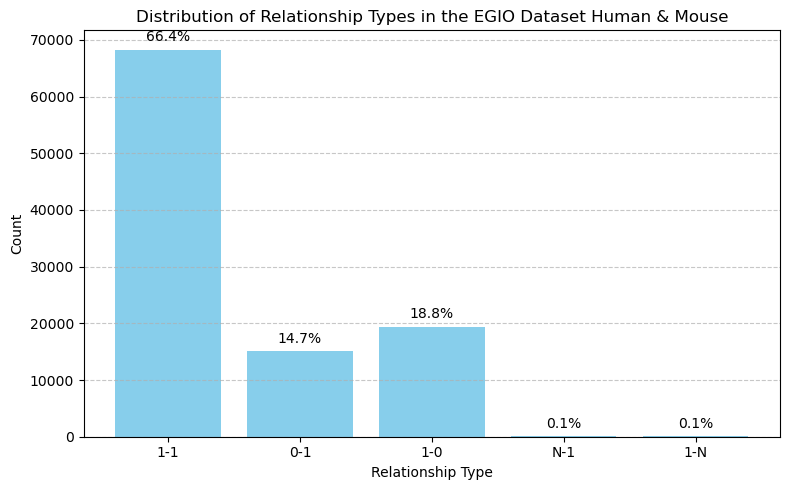

In [3]:
import matplotlib.pyplot as plt

# Data
relationship_types = ['1-1', '0-1', '1-0', 'N-1', '1-N']
counts = [68279, 15091, 19362, 75, 96]
percentages = [66.4, 14.7, 18.8, 0.07, 0.09]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(relationship_types, counts, color='skyblue')

# Add counts and percentages as labels
for bar, count, pct in zip(bars, counts, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1000, f"{pct:.1f}%", 
             ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Relationship Types in the EGIO Dataset Human & Mouse")
plt.xlabel("Relationship Type")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd

# Load your dataset (adjust the path accordingly)
df = pd.read_csv("/cosybio/project/mabouzid/EEI_networks/EEI-Conservation-main/EGIO/results/ExonGroup_testpro_hsa_mus.txt", sep="\t")

# Quick look
print(df['Iden'].describe())

count    102903.000000
mean          0.574224
std           0.416390
min           0.000000
25%           0.000000
50%           0.840000
75%           0.900000
max           1.000000
Name: Iden, dtype: float64


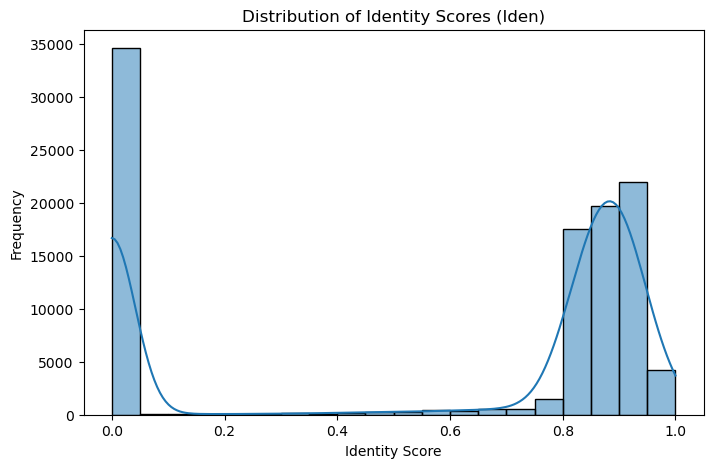

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['Iden'], bins=20, kde=True)
plt.title('Distribution of Identity Scores (Iden)')
plt.xlabel('Identity Score')
plt.ylabel('Frequency')
plt.show()


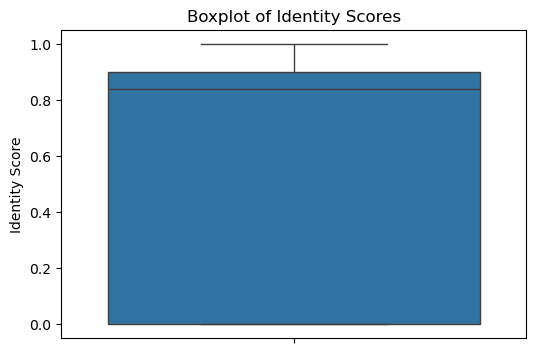

In [6]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=df['Iden'])
plt.title('Boxplot of Identity Scores')
plt.ylabel('Identity Score')
plt.show()


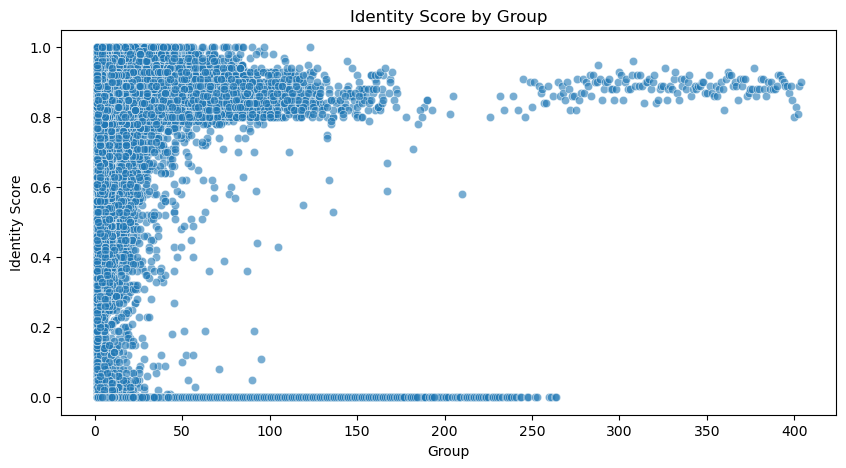

In [7]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['Group'], y=df['Iden'], alpha=0.6)
plt.title('Identity Score by Group')
plt.xlabel('Group')
plt.ylabel('Identity Score')
plt.show()


In [8]:
df_filtered = df[df['Iden'] > 0]

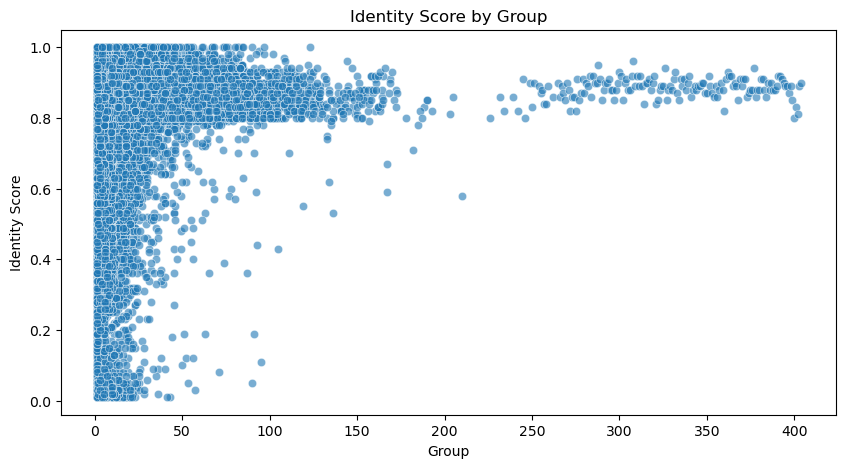

In [10]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_filtered['Group'], y=df_filtered['Iden'], alpha=0.6)
plt.title('Identity Score by Group')
plt.xlabel('Group')
plt.ylabel('Identity Score')
plt.show()

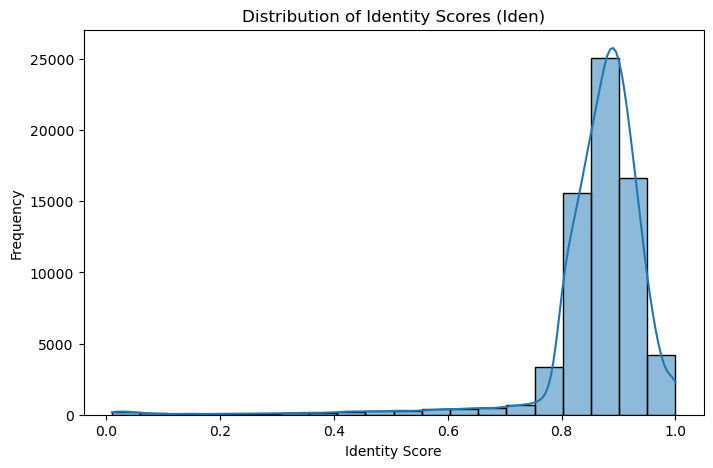

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(df_filtered['Iden'], bins=20, kde=True)
plt.title('Distribution of Identity Scores (Iden)')
plt.xlabel('Identity Score')
plt.ylabel('Frequency')
plt.show()

In [15]:
df_sorted = df_filtered.sort_values(by='Iden', ascending=True)


In [19]:
df_filtered_type = df[df['Type'] == '1-1']
df_filtered_type.head()

,Group,hsaEnsemblG,hsaPos,musEnsemblG,musPos,Iden,Type
0,1,ENSG00000155657,chr2:178804552:178804642:-1,ENSMUSG00000051747,chr2:76810436:76810526:-1,0.97,1-1
1,2,ENSG00000155657,chr2:178802138:178802341:-1,ENSMUSG00000051747,chr2:76807437:76807640:-1,0.95,1-1
2,3,ENSG00000155657,chr2:178800395:178800682:-1,ENSMUSG00000051747,chr2:76805255:76805542:-1,0.94,1-1
3,4,ENSG00000155657,chr2:178799825:178799910:-1,ENSMUSG00000051747,chr2:76804695:76804780:-1,0.91,1-1
4,5,ENSG00000155657,chr2:178799487:178799731:-1,ENSMUSG00000051747,chr2:76804360:76804601:-1,0.90,1-1


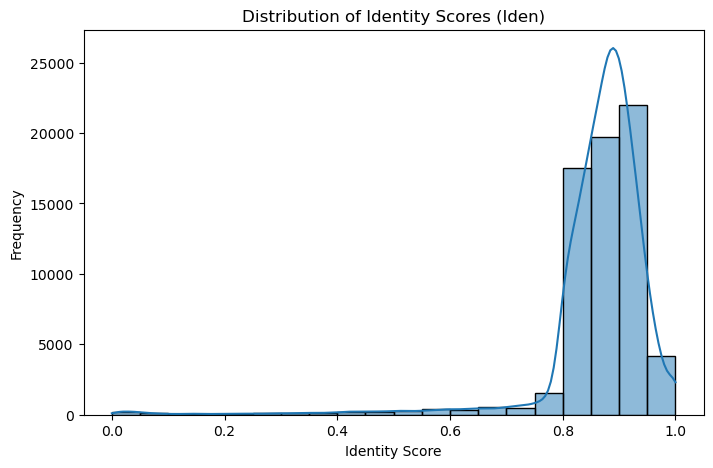

In [20]:
plt.figure(figsize=(8, 5))
sns.histplot(df_filtered_type['Iden'], bins=20, kde=True)
plt.title('Distribution of Identity Scores (Iden)')
plt.xlabel('Identity Score')
plt.ylabel('Frequency')
plt.show()

In [21]:
df_sorted1 = df_filtered_type.sort_values(by='Iden', ascending=True)
df_sorted1.head()

,Group,hsaEnsemblG,hsaPos,musEnsemblG,musPos,Iden,Type
89829,6,ENSG00000172992,chr17:45029571:45029571:-1,ENSMUSG00000020935,chr11:102885707:102885998:-1,0.0,1-1
97526,6,ENSG00000230797,chrX:21856485:21857603:1,ENSMUSG00000046873,chrX:156352090:156352094:-1,0.0,1-1
34674,2,ENSG00000106624,chr7:44106240:44106240:1,ENSMUSG00000020473,chr11:5812152:5812398:1,0.0,1-1
41836,15,ENSG00000188089,chr15:41993649:41993649:-1,ENSMUSG00000050211,chr2:120075167:120075388:-1,0.0,1-1
7809,30,ENSG00000159433,chr15:42694460:42694472:1,ENSMUSG00000033705,chr2:120526225:120536061:1,0.0,1-1


In [25]:
zero_iden_count = (df_filtered_type['Iden'] == 0.03).sum()
zero_iden_count

44